In [338]:
import math
import pandas as pd
import argparse

In [339]:
# Constants

case = {
    1: {'name': "Swale",
        'n': 0.013,
        'b': 0,
        'z': 0.300/0.150,
        },
    2: {'name': "Deep Swale",
        'n': 0.013,
        'b': 0.15,
        'z': 0.225/0.300,
        },
    3: {'name': "Gravel Lane",
        'n': 0.022,
        'b': 0,
        'z': 1/0.035,
        },
    4: {'name': "Paved Lane",
        'n': 0.013,
        'b': 0,
        'z': 1/0.020,
        },
    5: {'name': "Circular Pipe (PVC)",
        'n': 0.011,
        },
    6: {'name': "Circular Pipe (Concrete)",
        'n': 0.013,
        },
    7: {'name': "Road",
        'n': 0.013,
        'curb': {
            'std': {
                'curb_face_height': 0.14,
                'curb_face_depth': 0.015,
                'curb_top_width': 0.150,
                'gutter_depth': 0.025,
                'gutter_width': 0.25,
            },
            'rolled': {
                'curb_face_height': 0.100,
                'curb_face_depth': 0.550 - 0.250 - 0.025 - 0.024,
                'curb_top_width': 0.024,
                'gutter_depth': 0.025,
                'gutter_width': 0.25,
            }, }
        },
}

# Trapezoidal Cross Section

To find the depth of flow in a trapezoidal channel using Manning’s equation, you need to use the following steps and formulas:

1. **Manning’s Equation**:

    $ Q = \frac{1}{n} A R^{2/3} S^{1/2} $

    Where:

    - $ Q $ = flow rate (m³/s)
    - $ n $ = Manning’s roughness coefficient
    - $ A $ = cross-sectional area of flow (m²)
    - $ R $ = hydraulic radius (m)
    - $ S $ = slope of the channel (%)

2. **Cross-Sectional Area for a Trapezoidal Channel**:

    $A = (b + zy) y$

    Where:

    - $ b $ = bottom width of the channel (m)
    - $ z $ = side slope (horizontal distance per unit vertical distance)
    - $ y $ = depth of flow (m)

3. **Wetted Perimeter for a Trapezoidal Channel**:
   $ P = b + 2y \sqrt{1 + z^2} $

4. **Hydraulic Radius**:
   $ R = \frac{A}{P} $

To find the depth $ y $, follow these steps:

1. Express the cross-sectional area $ A $ and wetted perimeter $ P $ in terms of $ y $:
   $ A = \left(b + zy\right) y $
   $ P = b + 2y \sqrt{1 + z^2} $

2. Substitute these into the hydraulic radius formula:
   $ R = \frac{\left(b + zy\right) y}{b + 2y \sqrt{1 + z^2}} $

3. Substitute $ A $ and $ R $ into Manning’s equation:
   $ Q = \frac{1}{n} \left[\left(b + zy\right) y\right] \left[\frac{\left(b + zy\right) y}{b + 2y \sqrt{1 + z^2}}\right]^{2/3} S^{1/2} $

4. This results in an equation that must be solved iteratively or using numerical methods to find the depth $ y $.

Here procedure for the iterative solution:

1. Assume an initial depth $ y $.
2. Calculate $ A $ using $ A = \left(b + zy\right) y $.
3. Calculate $ P $ using $ P = b + 2y \sqrt{1 + z^2} $.
4. Calculate $ R $ using $ R = \frac{A}{P} $.
5. Substitute $ A $, $ R $, and $ S $ into Manning’s equation to solve for $ Q $.
6. Compare the calculated $ Q $ with the given flow rate.
7. Adjust $ y $ and repeat steps 2-6 until the calculated $ Q $ matches the given $ Q $ within an acceptable tolerance.


In [340]:
def manning_trapezoid(Q, n, b, z, S, y_min=0.001, y_max=10, tolerance=1e-6, max_iterations=1000):
    def calculate_flow(y):
        A = (b + z * y) * y
        P = b + 2 * y * math.sqrt(1 + z * z)
        R = A / P
        return (1 / n) * A * (R ** (2/3)) * (S ** 0.5), A

    low, high = y_min, y_max
    for _ in range(max_iterations):
        mid = (low + high) / 2
        Q_mid, A = calculate_flow(mid)

        if abs(Q_mid - Q) < tolerance:
            return mid, A
        elif Q_mid < Q:
            low = mid
        else:
            high = mid
    raise ValueError(
        f"Solution did not converge within {max_iterations} iterations")

# Circular Cross Section

To find the depth of flow in a circular pipe using Manning’s equation, follow these steps and formulas:

1. **Manning’s Equation**:

    $ Q = \frac{1}{n} A R^{2/3} S^{1/2} $

    Where:

    - $ Q $ = flow rate (m³/s)
    - $ n $ = Manning’s roughness coefficient
    - $ A $ = cross-sectional area of flow (m²)
    - $ R $ = hydraulic radius (m)
    - $ S $ = slope of the pipe (%)

2. **Cross-Sectional Area for a Circular Pipe**:

    $ A = r^2 \cos^{-1} \left( \frac{r-h}{r} \right) - (r-h) \sqrt{2rh - h^2} $

    Where:

    - $ r $ = radius of the pipe (m)
    - $ h $ = depth of flow (m)

3. **Wetted Perimeter for a Circular Pipe**:

    $ P = r \theta $

    Where:

    - $ \theta $ is the central angle in radians, calculated as $ \theta = 2 \cos^{-1} \left( \frac{r-h}{r} \right) $

4. **Hydraulic Radius**:

    $ R = \frac{A}{P} $

To find the depth $ h $, follow these steps:

1. **Express the cross-sectional area $ A $ and wetted perimeter $ P $ in terms of $ h $**:
   $ A = r^2 \cos^{-1} \left( \frac{r-h}{r} \right) - (r-h) \sqrt{2rh - h^2} $
   $ P = r \theta $
   Where $ \theta = 2 \cos^{-1} \left( \frac{r-h}{r} \right) $

2. **Substitute these into the hydraulic radius formula**:
   $ R = \frac{r^2 \cos^{-1} \left( \frac{r-h}{r} \right) - (r-h) \sqrt{2rh - h^2}}{r \theta} $

3. **Substitute $ A $ and $ R $ into Manning’s equation**:
   $ Q = \frac{1}{n} \left[ r^2 \cos^{-1} \left( \frac{r-h}{r} \right) - (r-h) \sqrt{2rh - h^2} \right] \left[ \frac{r^2 \cos^{-1} \left( \frac{r-h}{r} \right) - (r-h) \sqrt{2rh - h^2}}{r \theta} \right]^{2/3} S^{1/2} $

4. **This results in an equation that must be solved iteratively or using numerical methods to find the depth $ h $**.

_Procedure for the Iterative Solution:_

1. Assume an initial depth $ h $.
2. Calculate $ A $ using $ A = r^2 \cos^{-1} \left( \frac{r-h}{r} \right) - (r-h) \sqrt{2rh - h^2} $.
3. Calculate $ \theta $ using $ \theta = 2 \cos^{-1} \left( \frac{r-h}{r} \right) $.
4. Calculate $ P $ using $ P = r \theta $.
5. Calculate $ R $ using $ R = \frac{A}{P} $.
6. Substitute $ A $, $ R $, and $ S $ into Manning’s equation to solve for $ Q $.
7. Compare the calculated $ Q $ with the given flow rate.
8. Adjust $ h $ and repeat steps 2-7 until the calculated $ Q $ matches the given $ Q $ within an acceptable tolerance.


In [341]:
def manning_circular(Q, n, D, S, tolerance=1e-6, max_iterations=1000):
    def calculate_flow(h):
        r = D / 2
        A = r**2 * math.acos((r-h)/r) - (r - h) * math.sqrt(2*r*h-h**2)
        P = D * math.acos((r - h) / r)
        R = A / P
        return (1 / n) * A * (R ** (2/3)) * (S ** 0.5), A

    low, high = 0.001, D
    for _ in range(max_iterations):
        mid = (low + high) / 2
        Q_mid, A = calculate_flow(mid)

        if abs(Q_mid - Q) < tolerance:
            return mid, A
        elif Q_mid < Q:
            low = mid
        else:
            high = mid
    raise ValueError(
        f"Solution did not converge within {max_iterations} iterations")

# Road Cross Section


In [342]:
# Calculate Road Crown

def calculate_road_crown():
    return 0.02

## Calculate Road Area


In [343]:

def calculate_road_area(d, road_width=10, ROW=15, road_slope=0.02, row_slope=0.02, curb_constants={
    'curb_face_height': 0.14,
    'curb_face_depth': 0.015,
    'curb_top_width': 0.150,
    'gutter_depth': 0.025,
    'gutter_width': 0.25,
}):
    # Constants
    curb_face_height = curb_constants['curb_face_height']
    curb_face_depth = curb_constants['curb_face_depth']
    curb_top_width = curb_constants['curb_top_width']
    gutter_depth = curb_constants['gutter_depth']
    gutter_width = curb_constants['gutter_width']

    gutter_slope = (gutter_depth / gutter_width)
    curb_slope = (curb_face_height / curb_face_depth)
    ROW_width = ROW / 2 - road_width / 2 - \
        gutter_width - curb_face_depth - curb_top_width

    # Calculate depth
    d_L1 = d_R1 = d_L2 = d_R2 = d_L3 = d_R3 = 0

    if d < gutter_depth:
        d_L1 = d
    else:
        d_L1 = gutter_depth
        if d < (road_width / 2 * road_slope) + gutter_depth:
            d_L2 = d - gutter_depth
        else:
            d_L2 = (road_width / 2 * road_slope)

            d_L3 = d - gutter_depth - (road_width / 2 * road_slope)
            if d_L3 < 0:
                d_L3 = 0

        if d < curb_face_height:
            d_R1 = d
        else:
            d_R1 = curb_face_height
            d_R2 = d - curb_face_height
            if d_R2 > (ROW_width * row_slope):
                # print(f"Depth of {d} m will fill entire ROW width. ")
                d_R2 = ROW_width * row_slope
                d_R3 = d - (ROW_width * row_slope) - curb_face_height

    # Calculate area
    A_L1 = d_L1 ** 2 / (2 * gutter_slope)  # triangle
    A_L2 = gutter_width * d_L2  # rectangle
    A_L3 = (d_L2 ** 2) / (2 * road_slope)  # triangle
    A_L4 = (road_width + gutter_width) * d_L3  # rectangle

    A_R1 = d_R1 ** 2 / (2 * curb_slope)  # triangle
    A_R2 = d_R2 * (curb_face_depth + curb_top_width)  # rectangle
    A_R3 = d_R2 ** 2 / (2 * row_slope)  # triangle
    A_R4 = d_R3 * ROW_width  # rectangle

    A = A_L1 + A_L2 + A_L3 + A_L4 + A_R1 + A_R2 + A_R3 + A_R4

    P_L1 = P_L2 = P_R1 = P_R2 = P_R3 = 0

    # Calculate wetted perimeter
    P_L1 = math.sqrt(d_L1**2 + (d_L1 / gutter_slope)**2)
    P_L2 = math.sqrt(d_L2**2 + (d_L2 / road_slope)**2)

    P_R1 = math.sqrt(d_R1**2 + (d_R1 / curb_slope)**2)
    P_R2 = curb_top_width if d > curb_face_height else 0
    P_R3 = math.sqrt(d_R3**2 + (d_R3 / row_slope)**2)

    P = P_L1 + P_L2 + P_R1 + P_R2 + P_R3

    # print(d, "left: ", d_L1, d_L2, d_L3, "right:", d_R1, d_R2, d_R3)
    # print(P, "left: ", P_L1, P_L2, "right:", P_R1, P_R2, P_R3)

    return A * 2, P * 2

### Test


In [344]:
# Calculate Q given 0.1 depth, road xs and slope in m/m
S = 1/100
d = 0.3

A, P = calculate_road_area(d)
n = 0.013
R = A / P
Q, A = (1 / n) * A * (R ** (2/3)) * (S ** 0.5), A
print(f"{Q*1000:.2f} L/s")

12750.97 L/s


In [345]:
def manning_road(Q, n, S, w, row, curb_constants, y_min=0.001, y_max=10, tolerance=1e-6, max_iterations=1000):

    def calculate_flow(d):
        A, P = calculate_road_area(
            d, w, row, crown, curb_constants=curb_constants)
        R = A / P
        return (1 / n) * A * (R ** (2/3)) * (S ** 0.5), A

    low, high = y_min, y_max
    crown = calculate_road_crown()
    for _ in range(max_iterations):
        mid = (low + high) / 2
        Q_mid, A = calculate_flow(mid)

        if abs(Q_mid - Q) < tolerance:
            return mid, A, crown
        elif Q_mid < Q:
            low = mid
        else:
            high = mid
    raise ValueError(
        f"Solution did not converge within {max_iterations} iterations")

# Calculate Depth


In [346]:

def calculate_depth(row):
    depth = area = crown = 0
    if row['Type'] == "Swale":
        params = case[1]
        depth, area = manning_trapezoid(
            row['Peak Discharge'], params['n'], params['b'], params['z'], row['Slope']/100)
    elif row['Type'] == "Deep Swale":
        params = case[2]
        depth, area = manning_trapezoid(
            row['Peak Discharge'], params['n'], params['b'], params['z'], row['Slope']/100)
    elif row['Type'] == "Gravel Lane":
        params = case[3]
        depth, area = manning_trapezoid(
            row['Peak Discharge'], params['n'], params['b'], params['z'], row['Slope']/100)
    elif row['Type'] == "Paved Lane":
        params = case[4]
        depth, area = manning_trapezoid(
            row['Peak Discharge'], params['n'], params['b'], params['z'], row['Slope']/100)
    elif row['Type'] == "Circular Pipe (PVC)":
        params = case[5]
        D = float(row['Diameter'])
        depth, area = manning_circular(
            row['Peak Discharge'], params['n'], D, row['Slope']/100)
    elif row['Type'] == "Circular Pipe (Concrete)":
        params = case[6]
        D = float(row['Diameter'])
        depth, area = manning_circular(
            row['Peak Discharge'], params['n'], D, row['Slope']/100)
    elif row['Type'] == "Road":
        params = case[7]
        curb_constants = params['curb'][row["Curb"]]
        depth, area, crown = manning_road(
            Q=row['Peak Discharge'], n=params['n'], S=row['Slope']/100, w=row['Road Width'], row=row['ROW'], curb_constants=curb_constants)
    else:
        raise ValueError(f"Unknown type: {row['Type']}")
    return depth, area, crown if crown else None

In [347]:
def plot_graph(data):
    df = pd.DataFrame([[0.5, 0.8], [1.0, 0.32], [2.0, 0.21], [3.0, 0.09]], columns=[
        "Water Velocity", "Permissible Depth"])

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.plot(df["Water Velocity"], df["Permissible Depth"], color="black")
    plt.scatter(data['Flow Velocity'], data["Flow Depth"],
                marker="d", color='red')

    plt.xlabel("Velocity (m/s)")
    plt.ylabel("Depth (m)")

    plt.grid(color='grey', linestyle='-', linewidth=1)

    plt.xlim(left=0)
    plt.ylim((0, 1))

    plt.text(0.1, 0.35, "Acceptable")
    plt.text(2.1, 0.55, "Not Acceptable")

    plt.plot()

In [348]:
def main(input_file):
    data = pd.read_csv(input_file, header=0)

    data[['Flow Depth', 'Area', "Crown"]] = data.apply(
        lambda row: pd.Series(calculate_depth(row)), axis=1)

    data['Flow Velocity'] = data['Peak Discharge'] / data['Area']

    data.drop(['Area'], axis=1, inplace=True)

    new_column_order = ['Location Number', 'Peak Discharge',
                        'Slope', 'Location', 'Type', 'Flow Velocity', 'Flow Depth']

    data = data[new_column_order]

    result_name = input_file.replace('.csv', '_results.csv')

    data.to_csv(result_name, index=False)
    plot_graph(data)

    print(f"Results saved to {result_name}")

Results saved to ./data_road_results.csv


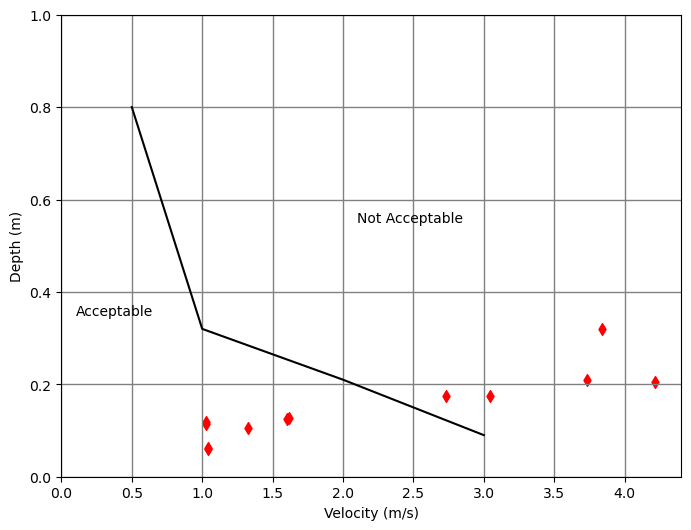

In [349]:
if __name__ == "__main__":
    # parser = argparse.ArgumentParser(
    #     description='Calculate depth and velocity for channels.')
    # parser.add_argument('input_file', type=str,
    #                     help='Path to the input CSV file')
    # args = parser.parse_args()

    # main(args.input_file)

    # main('./data_trapezoid.csv')
    # main('./data_circular.csv')
    main('./data_road.csv')

# Create Custom QVD Nomograph


Create data


In [350]:
import numpy as np
import pandas as pd

# Define the slope and peak discharge values
slopes = np.arange(0.5, 5.5, 0.5)
peak_discharges = [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 15, 20]
road_width = 10
row_width = 15

# Initialize an empty list to store the rows
data = []

# Create the data rows
location_number = 1
for slope in slopes:
    for peak_discharge in peak_discharges:
        row = [location_number, peak_discharge, slope,
               'Residential', 'Road', road_width, row_width, 'std']
        data.append(row)
        location_number += 1

# Create a DataFrame
columns = ['Location Number', 'Peak Discharge', 'Slope',
           'Location', 'Type', 'Road Width', 'ROW', 'Curb']
data = pd.DataFrame(data, columns=columns)

In [351]:
# Calculate Velocity and Depth
import matplotlib.pyplot as plt
data[['Flow Depth', 'Area', "Crown"]] = data.apply(
    lambda row: pd.Series(calculate_depth(row)), axis=1)

data['Flow Velocity'] = data['Peak Discharge'] / data['Area']

In [352]:
def label(Q, v, d):
    plt.text(v, d, Q, ha='left')

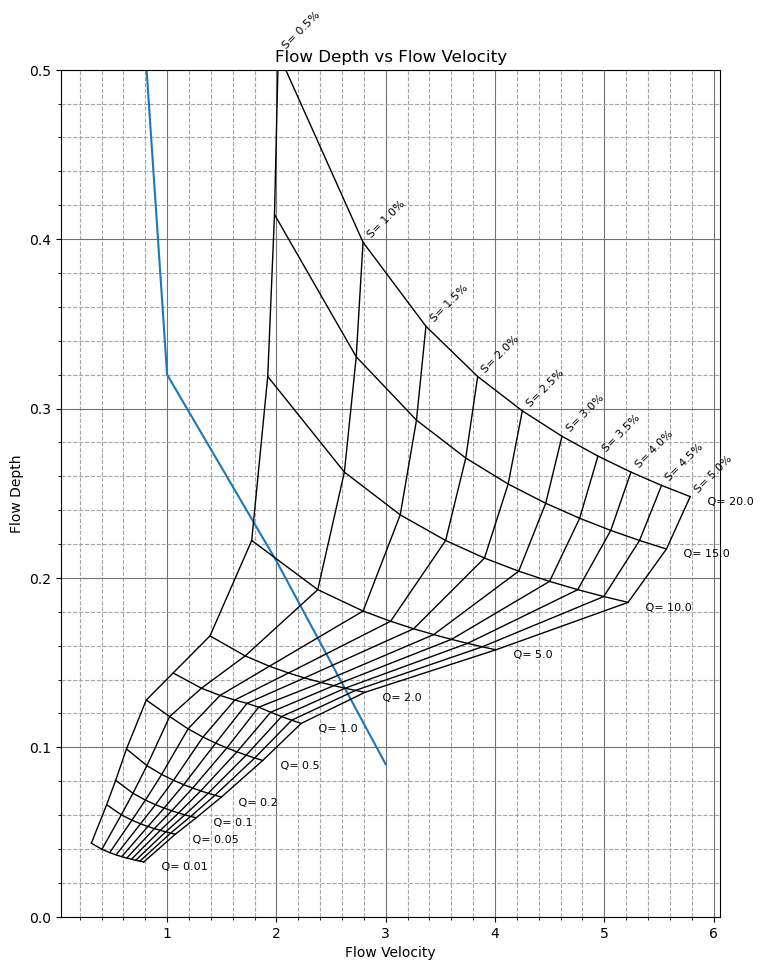

In [353]:
# Plotting
plt.figure(figsize=(8.5, 11))

# Plot Guideline
df = pd.DataFrame([[0.5, 0.8], [1.0, 0.32], [2.0, 0.21], [3.0, 0.09]], columns=[
    "Water Velocity", "Permissible Depth"])
plt.plot(df['Water Velocity'], df['Permissible Depth'],)

# Plot all points
# plt.scatter(data['Flow Velocity'], data['Flow Depth'], marker='.',
#             color='red', label='All Points')

# Connect points for each unique slope
unique_slopes = data['Slope'].unique()
for slope in unique_slopes:
    data_slope = data[data['Slope'] == slope]
    plt.plot(data_slope['Flow Velocity'], data_slope['Flow Depth'],
             color='black', linewidth=1, label=f'Slope = {slope}')

# Connect points for each unique peak discharge
unique_peak_discharges = data['Peak Discharge'].unique()
for peak_discharge in unique_peak_discharges:
    data_peak = data[data['Peak Discharge'] == peak_discharge]
    plt.plot(data_peak['Flow Velocity'], data_peak['Flow Depth'], color='black', linewidth=1,
             label=f'Peak Discharge = {peak_discharge}')

# Label the slope lines
df_slope = data[data['Peak Discharge'] == max(unique_peak_discharges)]
for i, row in df_slope.iterrows():
    plt.text(row['Flow Velocity'], row['Flow Depth'],
             f' S= {row["Slope"]}%', fontsize=8, ha='left', va='bottom', rotation=45)

# Label the discharge lines
df_discharge = data[data['Slope'] == max(unique_slopes)]
for i, row in df_discharge.iterrows():
    plt.text(row['Flow Velocity'], row['Flow Depth'],
             f'     Q= {row["Peak Discharge"]}', fontsize=8, ha='left', va='top')


# Customize the plot
plt.ylabel('Flow Depth')
plt.xlabel('Flow Velocity')
plt.title('Flow Depth vs Flow Velocity')
plt.minorticks_on()
plt.grid(which='major', color='0.45', linestyle='-')
plt.grid(which='minor', color='0.65', linestyle='--')
plt.ylim((0, 0.5))
plt.show()

In [354]:
data[data['Slope'] == 2.0]

,Location Number,Peak Discharge,Slope,Location,Type,Road Width,ROW,Curb,Flow Depth,Area,Crown,Flow Velocity
33,34,0.01,2.0,Residential,Road,10,15,std,0.036492,0.018742,0.02,0.533552
34,35,0.05,2.0,Residential,Road,10,15,std,0.054851,0.066052,0.02,0.756980
35,36,0.10,2.0,Residential,Road,10,15,std,0.066131,0.111870,0.02,0.893892
36,37,0.20,2.0,Residential,Road,10,15,std,0.080525,0.188859,0.02,1.058992
37,38,0.50,2.0,Residential,Road,10,15,std,0.106048,0.376418,0.02,1.328310
38,39,1.00,2.0,Residential,Road,10,15,std,0.127914,0.617747,0.02,1.618785
39,40,2.00,2.0,Residential,Road,10,15,std,0.143884,0.947516,0.02,2.110782
40,41,5.00,2.0,Residential,Road,10,15,std,0.174414,1.641914,0.02,3.045226
41,42,10.00,2.0,Residential,Road,10,15,std,0.222102,2.818117,0.02,3.548469
42,43,15.00,2.0,Residential,Road,10,15,std,0.270763,4.018583,0.02,3.732659
